In [1]:
#The code for this notebook was based on code from here: 
#https://medium.com/radon-dev/implicit-bayesian-personalized-ranking-in-tensorflow-b4dfa733c478

import tensorflow as tf
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,dok_matrix
from math import ceil

from tqdm import tqdm_notebook as tqdm

In [2]:
tqdm().pandas()

In [3]:
#Read the puzzzle attempts data
df = pd.read_csv('/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00')
print(df.shape)

(129998184, 15)


In [4]:
#Filter for palyers that have played at least 1000 games
df = df.loc[df['userGamesPlayed'] >= 1000]
#Filter to get only successful attempts
df = df.loc[df['is_passed'] == 1]

In [5]:
df.shape

(29604286, 15)

In [6]:
#Get a table of user ratings and games played for each user in order to create metadata for user embeddings
user_data = df.groupby('user_hash')[['ratingUser','userGamesPlayed']].max()

In [7]:
#Filter out unnecessary columns
df = df[['user_hash','tactics_problem_id','is_passed']]
#Replace all missed attempt values with a -1 as to avoid confusion when creating sparse matrix
#df['is_passed'] = df['is_passed'].replace(0, -1,regex=True)
#Convert user_hashes and tactics_problem_id's to numerical category codes
df['user_id'] = df['user_hash'].astype("category").cat.codes
df['puzzle_id'] = df['tactics_problem_id'].astype("category").cat.codes
#Create lookup tables for user ID's and puzzle ID's for later reference
user_lookup = df[['user_id', 'user_hash']].drop_duplicates()
user_lookup['user_id'] = user_lookup.user_id
item_lookup = df[['tactics_problem_id', 'puzzle_id']].drop_duplicates()
df = df.drop('user_hash',axis=1)
df = df.drop('tactics_problem_id',axis=1)

In [8]:
#Get list of unique users and puzzles
users = list(np.sort(df.user_id.unique()))
puzzles = list(np.sort(df.puzzle_id.unique()))
#Convert all the attempt values to a list
is_passed = list(df.is_passed)

In [9]:
# Get the rows and columns for our new matrix
rows = df.user_id.astype(float)
cols = df.puzzle_id.astype(float)
# Contruct a sparse matrix for our users and items containing is_passed values
X = csr_matrix((is_passed, (rows, cols)), shape=(len(users), len(puzzles)))

In [10]:
def train_test_split(ratings,test_size=0.2,seed = 1352):
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in tqdm(range(ratings.shape[0])):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [11]:
X_train, X_test = train_test_split(X, test_size = 0.2, seed = 1234)
#Get Row and column values for attempted puzzles and the users that did them
uids, puzz_ids = X_train.nonzero()
#Get row and column values for attemptd puzzles in the test set
test_uids, test_puzz_ids = X_test.nonzero()

In [12]:
print(len(uids))
print(len(test_uids))

23671273
5933013


In [13]:
#-------------
# HYPERPARAMS
#-------------

epochs = 50
batches = 30
num_factors = 64 # Number of latent features

# Independent lambda regularization values 
# for user, items and bias.
lambda_user = 0.0000001
lambda_item = 0.0000001
lambda_bias = 0.0000001

# Our learning rate 
lr = 0.005

# How many (u,i,j) triplets we sample for each batch
samples = 15000

In [14]:
#-------------------------
# TENSORFLOW GRAPH
#-------------------------

# Set up our Tensorflow graph
graph = tf.Graph()

def init_variable(size, dim, name=None):
    '''
    Helper function to initialize a new variable with
    uniform random values.
    '''
    std = np.sqrt(2 / dim)
    return tf.Variable(tf.random_uniform([size, dim], -std, std), name=name)


def embed(inputs, size, dim, name=None):
    '''
    Helper function to get a Tensorflow variable and create
    an embedding lookup to map our user and item
    indices to vectors.
    '''
    emb = init_variable(size, dim, name)
    return tf.nn.embedding_lookup(emb, inputs)


def get_variable(graph, session, name):
    '''
    Helper function to get the value of a
    Tensorflow variable by name.
    '''
    v = graph.get_operation_by_name(name)
    v = v.values()[0]
    v = v.eval(session=session)
    return v

In [15]:
#Set up range of hyperparamters to try for tuning
'''
param1_values = np.linspace(12, 144, 4).astype('int')
param2_values = np.linspace(100, 15000, 4).astype('int')

print(param1_values)
print(param2_values)

all_combs = [(p1, p2) for p1 in param1_values for p2 in param2_values]
'''

"\nparam1_values = np.linspace(12, 144, 4).astype('int')\nparam2_values = np.linspace(100, 15000, 4).astype('int')\n\nprint(param1_values)\nprint(param2_values)\n\nall_combs = [(p1, p2) for p1 in param1_values for p2 in param2_values]\n"

In [16]:
with graph.as_default():
    '''
    Loss function: 
    -SUM ln σ(xui - xuj) + λ(w1)**2 + λ(w2)**2 + λ(w3)**2 ...
    ln = the natural log
    σ(xuij) = the sigmoid function of xuij.
    λ = lambda regularization value.
    ||W||**2 = the squared L2 norm of our model parameters.
    
    '''

    # Input into our model, in this case our user (u),
    # known item (i) an unknown item (j) triplets.
    u = tf.placeholder(tf.int32, shape=(None, 1))
    i = tf.placeholder(tf.int32, shape=(None, 1))
    j = tf.placeholder(tf.int32, shape=(None, 1))

    # User feature embedding
    u_factors = embed(u, len(users), num_factors, 'user_factors') # U matrix

    # Known and unknown item embeddings
    item_factors = init_variable(len(puzzles), num_factors, "puzzle_factors") # V matrix
    i_factors = tf.nn.embedding_lookup(item_factors, i)
    j_factors = tf.nn.embedding_lookup(item_factors, j)

    # i and j bias embeddings.
    item_bias = init_variable(len(puzzles), 1, "item_bias")
    i_bias = tf.nn.embedding_lookup(item_bias, i)
    i_bias = tf.reshape(i_bias, [-1, 1])
    j_bias = tf.nn.embedding_lookup(item_bias, j)
    j_bias = tf.reshape(j_bias, [-1, 1])

    # Calculate the dot product + bias for known and unknown
    # item to get xui and xuj.
    xui = i_bias + tf.reduce_sum(u_factors * i_factors, axis=2)
    xuj = j_bias + tf.reduce_sum(u_factors * j_factors, axis=2)

    # We calculate xuij.
    xuij = xui - xuj

    # Calculate the mean AUC (area under curve).
    # if xuij is greater than 0, that means that 
    # xui is greater than xuj (and thats what we want).
    u_auc = tf.reduce_mean(tf.to_float(xuij > 0))

    # Output the AUC value to tensorboard for monitoring.
    tf.summary.scalar('auc', u_auc)

    # Calculate the squared L2 norm ||W||**2 multiplied by λ.
    l2_norm = tf.add_n([
        lambda_user * tf.reduce_sum(tf.multiply(u_factors, u_factors)),
        lambda_item * tf.reduce_sum(tf.multiply(i_factors, i_factors)),
        lambda_item * tf.reduce_sum(tf.multiply(j_factors, j_factors)),
        lambda_bias * tf.reduce_sum(tf.multiply(i_bias, i_bias)),
        lambda_bias * tf.reduce_sum(tf.multiply(j_bias, j_bias))
        ])

    # Calculate the loss as ||W||**2 - ln σ(Xuij)
    #loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    loss = -tf.reduce_mean(tf.log(tf.sigmoid(xuij))) + l2_norm
    
    # Train using the Adam optimizer to minimize 
    # our loss function.
    opt = tf.train.AdamOptimizer(learning_rate=lr)
    step = opt.minimize(loss)

    # Initialize all tensorflow variables.
    init = tf.global_variables_initializer()

Instructions for updating:
Use `tf.cast` instead.


In [17]:
from sklearn.metrics import roc_auc_score

def test_auc(ratings,sample_size=100):
    """
    Calculate AUC for sample_size many randomly sampled users from the 
    test dataset and then return the average of these scores
    """
    # Grab our user matrix U
    user_vecs = get_variable(graph, session, 'user_factors')

    # Grab our item matrix V
    item_vecs = get_variable(graph, session, 'puzzle_factors')

    # Grab our item bias
    item_bi = get_variable(graph, session, 'item_bias').reshape(-1)
    
    auc = 0.0
    n_users, n_items = ratings.shape
    samples = np.random.choice(n_users,sample_size)
    
    #pbar = tqdm(total=sample_size)
    
    for i, row in enumerate(ratings[samples]):
        index = samples[i]
        scores = np.add(user_vecs[index].dot(item_vecs.T), item_bi)
        true = np.zeros(n_items)
        true[row.indices] = 1
        auc += roc_auc_score(true, scores)
        #pbar.update(1)
        
    #pbar.close()
    auc /= sample_size
    return auc

#print(test_auc(X_test,500))

In [18]:
#------------------
# GRAPH EXECUTION
#------------------
# Run the session. 
session = tf.Session(config=None, graph=graph)
session.run(init)
# This has noting to do with tensorflow but gives
# us a nice progress bar for the training.
progress = tqdm(total=batches*epochs)

auc_data = []
loss_data = []
vals = []
for _ in range(epochs):
    for _ in range(batches):

        # We want to sample one known and one unknown 
        # puzzle for each user. 

        # First we sample 15000 uniform indices.
        idx = np.random.randint(low=0, high=len(uids), size=samples)

        # We then grab the users matching those indices.
        batch_u = uids[idx].reshape(-1, 1)

        # Then the known items for those users.
        batch_i = puzz_ids[idx].reshape(-1, 1)

        # Lastly we randomly sample one unknown item for each user.
        batch_j = np.random.randint(
                low=0, high=len(puzzles), size=(samples, 1), dtype='int32')

        # Feed our users, known and unknown items to
        # our tensorflow graph. 
        feed_dict = { u: batch_u, i: batch_i, j: batch_j }

        # We run the session.
        _, l, auc = session.run([step, loss, u_auc], feed_dict)

        
    validation = test_auc(X_test)
    auc_data.append(auc)
    loss_data.append(l)
    vals.append(validation)
    print('Validation is: {}'.format(validation))
    progress.update(batches)
    progress.set_description('Loss: %.3f | AUC: %.3f' % (l, auc))
    
progress.close()
'''
scores = [] 
for pair in all_combs:
    #Set param 1 to value in comb
    num_factors = pair[0]
    #Set param 2 to value in comb
    samples = pair[1]
    sess = training_session()
    scores.append(test_auc(X_test,session=sess))
'''
#sess = training_session()
#test_auc(X_test,session=sess)

Validation is: 0.5186277425034098
Validation is: 0.5350330015933126
Validation is: 0.5449922221055794
Validation is: 0.5788513156423205
Validation is: 0.5834940123227582
Validation is: 0.6218297623118538
Validation is: 0.6442632535677493
Validation is: 0.7068139922903068
Validation is: 0.7697405230638695
Validation is: 0.7859997023890872
Validation is: 0.814863536897201
Validation is: 0.8584244618106522
Validation is: 0.862792572077265
Validation is: 0.8739392507618758
Validation is: 0.872024726011817
Validation is: 0.8772515048023625
Validation is: 0.8730935988757981
Validation is: 0.885215093890394
Validation is: 0.889210220561361
Validation is: 0.8933218168185247
Validation is: 0.89959713171843
Validation is: 0.8771737026586847
Validation is: 0.8786651380415443
Validation is: 0.88661360785651
Validation is: 0.8965786196730267
Validation is: 0.8972692838783974
Validation is: 0.8893679207173268
Validation is: 0.8923741345168337
Validation is: 0.8920311870915532
Validation is: 0.902630

'\nscores = [] \nfor pair in all_combs:\n    #Set param 1 to value in comb\n    num_factors = pair[0]\n    #Set param 2 to value in comb\n    samples = pair[1]\n    sess = training_session()\n    scores.append(test_auc(X_test,session=sess))\n'

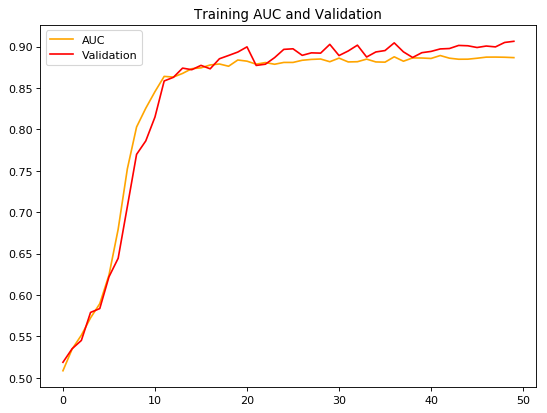

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

colors = ['orange','red']
labels = ['AUC','Validation']
figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for index,data in enumerate((auc_data,vals)):
    color = colors[index]
    label = labels[index]
    plt.plot(data,color=color,label=label)
             
plt.title('Training AUC and Validation')
plt.legend(loc=2)
#plt.savefig('../plots/presentation/training_validation_loss_bpr')
plt.show()

In [20]:
#Create heatmap for grid-search of hyperparameters
'''
reshaped = np.array(scores).reshape(4,4)
import matplotlib.pyplot as plt
#grid = np.arange(0, len(all_embeddings)).reshape((len(param1_values), len(param2_values)))

plt.figure(figsize=(6,6))
plt.imshow(reshaped)
plt.yticks(np.arange(0, len(param1_values)), ["%.2f" % d for d in param1_values])
plt.xticks(np.arange(0, len(param2_values)), ["%d" % d for d in param2_values])
plt.ylabel("Num of Latent Features")
plt.xlabel("Puzzle sample size")
plt.colorbar()
plt.show()
'''

'\nreshaped = np.array(scores).reshape(4,4)\nimport matplotlib.pyplot as plt\n#grid = np.arange(0, len(all_embeddings)).reshape((len(param1_values), len(param2_values)))\n\nplt.figure(figsize=(6,6))\nplt.imshow(reshaped)\nplt.yticks(np.arange(0, len(param1_values)), ["%.2f" % d for d in param1_values])\nplt.xticks(np.arange(0, len(param2_values)), ["%d" % d for d in param2_values])\nplt.ylabel("Num of Latent Features")\nplt.xlabel("Puzzle sample size")\nplt.colorbar()\nplt.show()\n'

In [21]:
puzzle_data = pd.read_csv('../important/tactics_problem_complete_data.csv')
puzzle_data.head()

,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,pgn,tag,full,fen
0,731,1569,44.96,53336,41,3,"Attacking f7/f2,Attacking Castled King,Back Ra...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",Attacking f7/f2,1. ... gxf6 2. Qxf8+ Kxf8 3. Bh6+ Kg8 4. Re8#,https://lichess.org/analysis/r1b2rk1/ppp2ppp/1...
1,732,1417,45.44,63725,26,2,"Basic Checkmates,Decoy / Deflection,Mate in 2,...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",Clearance Sacrifice,1. ... Rag8 2. Qxh7+ Rxh7 3. Rxg8#,https://lichess.org/analysis/r6k/1q1n1prp/p3pN...
2,738,2443,44.59,18115,54,3,"Back Rank,Discovered Attack,Fork / Double Atta...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",Back Rank,1. Kxf1 Nd2+ 2. Kg1 Re1+ 3. Kh2 Nf1+,https://lichess.org/analysis/3rr1k1/ppp2ppp/8/...
3,739,1795,44.97,41674,57,3,"Discovered Attack,Mate in 3+,Mating Net,Cleara...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",Double Check,1. ... Kf8 2. Qh8+ Ke7 3. Nf5+ exf5 4. Bc5#,https://lichess.org/analysis/3r2k1/pb1q1ppQ/1p...
4,740,2148,45.14,25701,88,5,"Discovered Attack,Mate in 3+,Mating Net,Double...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",Double Check,1. ... Kxd8 2. Nxe6+ Ke7 3. Bg5+ f6 4. Nd8+ Re...,https://lichess.org/analysis/3Qkb1r/pp3ppp/q3b...


In [22]:
item_lookup = pd.merge(item_lookup,puzzle_data,on='tactics_problem_id',how='inner')

<h2>Get data ready for projector</h2>

In [24]:
item_lookup.head()

,tactics_problem_id,puzzle_id,rating,rd,attempt_count,average_seconds,move_count,tags,pgn,tag,full,fen
0,31142,2796,1074,45.42,64176,28,2,"Back Rank,Decoy / Deflection,Remove the Defender","[Event ""?""]\n[Site ""Maribor""]\n[Date ""1967.??....",Back Rank,35. ... Qxb2 36. Rc8+ Rxc8 37. Qxb2,https://lichess.org/analysis/rr4k1/1q4p1/2Rp1n...
1,30498,2455,1633,45.01,48918,56,2,"Defense,Endgame Tactics,Pawn Promotion,Simplif...","[Event ""?""]\n[Site ""op, Calcutta IND""]\n[Date ...",Simplification,48. f4 Bxf5 49. fxg5 Kd5,https://lichess.org/analysis/8/3b4/8/5Np1/2k4p...
2,27538,740,818,44.10,52292,59,2,Fork / Double Attack,"[Event ""Online Chess""]\n[Site ""Chess.com""]\n[D...",Fork / Double Attack,8. ... c6 9. Bf4 Qxb2 10. Nc7+,https://lichess.org/analysis/rn2kb1r/ppp1pppp/...
3,29439,1855,733,41.93,44805,76,4,"Decoy / Deflection,Remove the Defender","[Event ""?""]\n[Site ""Thessaloniki olm""]\n[Date ...",Remove the Defender,33. ... Kf8 34. Qh8+ Ke7 35. Re1+ Re6 36. Rxe6...,https://lichess.org/analysis/4r1k1/1q3ppQ/2r5/...
4,29064,1643,986,43.76,57201,45,2,"Basic Checkmates,Mating Net,Sacrifice","[Event ""It (open)""]\n[Site ""Ljubljana (Sloveni...",Sacrifice,71. Qd8 Rxa2+ 72. Kxa2 Qa4+,https://lichess.org/analysis/8/4Q3/k1q5/5p2/r2...


In [ ]:
#Prepare the puzzle data for the projector

#Merge the item_lookup table with the puzzle metadata
item_meta = pd.merge(item_lookup,puzzle_data,on='tactics_problem_id')

#Get the puzzle embeddings and join 
item_vecs = get_variable(graph, session, 'puzzle_factors')
item_frame = pd.DataFrame(item_vecs)
item_frame = item_frame.reindex(item_meta['puzzle_id'])
item_frame = item_frame[item_frame.isnull() == False]

item_frame.to_csv('../../ChessPuzzleEmbeddings/bpr_vecs_highacc.tsv',
                 sep='\t',
                 index=False,
                 header=False)

item_meta.to_csv('../../ChessPuzzleEmbeddings/bpr_meta_highacc.tsv',
                 sep='\t',
                 index=False,
                 header=True,
                 encoding='utf-8')

In [25]:
user_meta = pd.merge(user_lookup,user_data,on='user_hash',how='inner')

In [ ]:
user_vecs = get_variable(graph,session,'user_factors')
user_frame = pd.DataFrame(user_vecs)
user_frame = user_frame.reindex(user_meta['user_id'])
user_frame = user_frame[user_frame.isnull() == False]

user_frame.to_csv('bpr_user_vecs.tsv',
                 sep='\t',
                 index=False,
                 header=False)

user_meta.to_csv('bpr_user_meta.tsv',
                 sep='\t',
                 index=False,
                 header=True,
                 encoding='utf-8')

In [ ]:
user_meta.head()

<h2>Puzzle Recommendations</h2>

In [26]:
def find_similar_puzzles(puzzle=None, num_items=10):
    """Find puzzles similar to another puzzle based on the users that complete it.
    Args:
        puzzle (int): The ID of the puzzle we want to find similar puzzles for
        num_items (int): How many similar puzzles we want to return.
    Returns:
        similar (pandas.DataFrame): DataFrame with num_items puzzles names and scores
    """

    # Grab our User matrix U
    user_vecs = get_variable(graph, session, 'user_factors')

    # Grab our Item matrix V
    item_vecs = get_variable(graph, session, 'puzzle_factors')

    # Grab our item bias
    item_bi = get_variable(graph, session, 'item_bias').reshape(-1)

    # Get the item id for the puzzle
    item_id = int(item_lookup[item_lookup.tactics_problem_id == puzzle]['puzzle_id'])

    # Get the item vector for our item_id and transpose it.
    item_vec = item_vecs[item_id].T

    scores = np.add(item_vecs.dot(item_vec), item_bi).reshape(1,-1)[0]

    # Get the indices for the top 10 scores
    top_10 = np.argsort(scores)[::-1][:num_items]

    # We then use our lookup table to grab the names of these indices
    # and add it along with its score to a pandas dataframe.
    puzzles, puzzle_scores = [], []
    
    for idx in top_10:
        try:
            puzzles.append(item_lookup.tactics_problem_id.loc[item_lookup.puzzle_id == idx].iloc[0])
            puzzle_scores.append(scores[idx])
        except:
            pass
    similar = pd.DataFrame({'tactics_problem_id': puzzles, 'score': puzzle_scores})
    similar = pd.merge(similar,puzzle_data[['tactics_problem_id','tags','rating','fen','full']],on='tactics_problem_id',how='left')
    return similar


find_similar_puzzles(puzzle=31142)

,tactics_problem_id,score,tags,rating,fen,full
0,195038,4.908939,"Decoy / Deflection,Fork / Double Attack,Mate i...",1283,https://lichess.org/analysis/1B2k3/p3b1p1/4p3/...,23. Bf4 Nf3+ 24. Rxf3 Qxg2#
1,90217,4.854404,"Defense,Hanging Piece",805,https://lichess.org/analysis/2r1kb1r/p3pppp/np...,17. Nxd6+ Qxd6
2,104985,4.843050,"Exchange Sacrifice,Hanging Piece,Vulnerable King",1414,https://lichess.org/analysis/8/1Q3p2/3qbk2/1P1...,36. Bf5 Qxe5
3,31142,4.746570,"Back Rank,Decoy / Deflection,Remove the Defender",1074,https://lichess.org/analysis/rr4k1/1q4p1/2Rp1n...,35. ... Qxb2 36. Rc8+ Rxc8 37. Qxb2
4,34716,4.718121,Zwischenzug,829,https://lichess.org/analysis/r7/7k/8/3P4/1pp4P...,43. ... Ra2 44. Re7+ Kg6 45. Qxa2
5,49404,4.645564,Trapped Piece,1110,https://lichess.org/analysis/rnb1kbnr/ppp2ppp/...,7. ... Nc6 8. Bg5 Qxg5 9. Nxg5
6,111319,4.642885,"Mate in 3+,Clearance Sacrifice",1188,https://lichess.org/analysis/r2qr1k1/pp1n3p/2p...,24. ... exd5 25. Rxg6+ hxg6 26. Qh8+ Kf7 27. Qg7#
7,28573,4.632152,"Mate in 1,Pin",1423,https://lichess.org/analysis/r1b1k2N/ppp3pp/8/...,16. Kd2 Nf3#
8,35529,4.629028,"Mating Net,Vulnerable King",1056,https://lichess.org/analysis/rnbq2kr/pp1p2b1/2...,14. ... Qf8 15. f7+
9,54978,4.601310,Mate in 1,980,https://lichess.org/analysis/B1b4r/3p4/p2P2R1/...,36. ... Ke5 37. Rf5#


In [29]:
#---------------------
# MAKE RECOMMENDATION
#---------------------

def make_recommendation(user_id=None, num_items=10):
    """Recommend items for a given user given a trained model
    Args:
        user_id (int): The id of the user we want to create recommendations for.
        num_items (int): How many recommendations we want to return.
    Returns:
        recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores
    """

    # Grab our user matrix U
    user_vecs = get_variable(graph, session, 'user_factors')

    # Grab our item matrix V
    item_vecs = get_variable(graph, session, 'puzzle_factors')

    # Grab our item bias
    item_bi = get_variable(graph, session, 'item_bias').reshape(-1)

    # Calculate the score for our user for all items. 
    rec_vector = np.add(user_vecs[user_id, :].dot(item_vecs.T), item_bi)

    # Grab the indices of the top puzzles
    item_idx = np.argsort(rec_vector)[::-1][:num_items]

    # Map the indices to artist names and add to dataframe along with scores.
    puzzles, puzzle_scores = [], []

    for idx in item_idx:
        puzzles.append(item_lookup.tactics_problem_id.loc[item_lookup.puzzle_id == idx].iloc[0])
        puzzle_scores.append(rec_vector[idx])

    
    recs = pd.DataFrame({'tactics_problem_id': puzzles, 'score': puzzle_scores})
    recs = pd.merge(recs,puzzle_data[['tactics_problem_id','tag','rating','fen','full']],on='tactics_problem_id',how='left')
    return recs

#Sort user meta by rating
user_meta.sort_values(by='ratingUser',inplace=True)
#Get the reccomended puzzles for a low user
lowuser = user_meta.iloc[1].user_id
make_recommendation(user_id=lowuser)

,tactics_problem_id,score,tag,rating,fen,full
0,124904,5.775882,Mate in 2,419,https://lichess.org/analysis/r1b1k2r/pppp2pp/8...,12. Rf5 Qxh2+ 13. Kf1 Qh1#
1,111941,5.764602,Mate in 2,400,https://lichess.org/analysis/r6k/pb2q3/npp1p1Q...,22. ... Qh7 23. Qf6+ Qg7 24. Qxg7#
2,87286,5.764546,Mate in 1,425,https://lichess.org/analysis/5r1k/6pp/7b/P2Q4/...,29. Kd1 Qd2#
3,149405,5.746862,Mate in 1,400,https://lichess.org/analysis/r5k1/2qb1ppp/p7/1...,19. Ng5 Qxh2#
4,82526,5.743651,Mate in 2,400,https://lichess.org/analysis/4rr1k/p1pq1p1n/2p...,26. ... Nf6 27. Qxf6+ Kh7 28. Qg7#
5,175390,5.732563,Mate in 1,400,https://lichess.org/analysis/r2q1rk1/3b1pp1/p3...,21. ... Nxf1 22. Qxg7#
6,71361,5.728631,Mate in 1,426,https://lichess.org/analysis/1Q4nr/5k2/p4b2/8/...,27. Kg1 Qh1#
7,82746,5.713660,Mate in 1,400,https://lichess.org/analysis/rn1qkb1r/ppp3pp/3...,8. ... c6 9. Qf7#
8,101507,5.704401,Mate in 2,407,https://lichess.org/analysis/6k1/p2r1ppp/1p1N4...,24. ... Re7 25. Qc8+ Re8 26. Qxe8#
9,71896,5.697987,Mate in 2,402,https://lichess.org/analysis/r2q1bkr/ppp1n2p/2...,9. ... Bg7 10. Qe6+ Kf8 11. Qf7#


<h2>Find average differene in rating between target and reccomended puzzles</h2>

In [31]:
#Get average absolute error in ratings between puzzle and top ten predictions
def get_average_error(puzzle):
    preds = find_similar_puzzles(puzzle)
    given_rating = item_lookup.loc[item_lookup.tactics_problem_id == puzzle]['rating'].iloc[0]
    preds['diff'] = abs(given_rating - preds['rating'])
    average = preds['diff'].agg('mean')
    return average

#Get average absolute difference for 10 random puzzles
def get_rand_average(puzzle):
    indices = np.random.choice(item_lookup.index,10)
    puzzles = item_lookup.iloc[indices]
    given_rating = item_lookup.loc[item_lookup.tactics_problem_id == puzzle]['rating'].iloc[0]
    diff = abs(given_rating - puzzles['rating'])
    return diff.agg('mean')

num_samples = 5000
puzzles = np.random.choice(item_lookup['tactics_problem_id'],num_samples)
averages = []
for puzzle in tqdm(puzzles):
    averages.append(get_average_error(puzzle))

print(sum(averages)/len(averages))
print(np.var(averages)**0.5)


257.03824563492014
425.43468735214196


In [32]:
rand_averages = []
for puzzle in tqdm(puzzles):
    rand_averages.append(get_rand_average(puzzle))
    
print(sum(rand_averages)/len(rand_averages))
print(np.var(rand_averages)**0.5)


737.4899399999997
365.58954183728565


<h2>Success Prediction Test</h2> 

In [33]:
def higher_score(user,puzzle_1,puzzle_2):
    '''
    Returns true if the puzzle_1 has a higher score than puzzle_2, false if not
    '''
    
    #Get user ID from username
    user_id = user_lookup.loc[user_lookup.user_hash == user]['user_id']
    
    #Get puzzle_IDs from tactics_problem_ids
    id_1 = item_lookup.loc[item_lookup.tactics_problem_id == puzzle_1]['puzzle_id'].iloc[0]
    id_2 = item_lookup.loc[item_lookup.tactics_problem_id == puzzle_2]['puzzle_id'].iloc[0]
    
    
    # Grab our user matrix U
    user_vecs = get_variable(graph, session, 'user_factors')

    # Grab our item matrix V
    item_vecs = get_variable(graph, session, 'puzzle_factors')

    # Grab our item bias
    item_bi = get_variable(graph, session, 'item_bias').reshape(-1)

    # Calculate the score for our user for all items. 
    rec_vector = np.add(user_vecs[user_id, :].dot(item_vecs.T), item_bi)[0]
    # Grab the indices of the top puzzles
    item_idx = np.argsort(rec_vector)[::-1]
    
    return rec_vector[id_1] > rec_vector[id_2]

higher_score('2e3f96438c113cb00b724c2b0b5399ed66bc7451207a63a3b45ca40b4b37d700',32910,33634)

True

In [34]:
pred_data = pd.read_csv('prediction_data_same_rating_shuffled.csv')

In [35]:
pred_data.shape

(161828, 10)

In [42]:
sample_size = 10000

def pass_prediction(row):
    pred = 1
    puzzle_1_closer = higher_score(row['user_hash'],row['puzzle_1'],row['puzzle_2'])
    
    if puzzle_1_closer:
        pred = 0
        
    if pred == row['passed_puzzle']:
        return 1
#Get predictions on sampled data
#indices = np.random.choice(pred_data.index,sample_size)
#ans = pred_data.iloc[indices].progress_apply(lambda x: pass_prediction(x),axis=1)
#print('Accuracy is: {}'.format(ans.fillna(0).sum()/sample_size))
#Get predictions on whole dataset
ans = pred_data.progress_apply(lambda x: pass_prediction(x),axis=1)
print('Accuracy is: {}'.format(ans.fillna(0).sum()/pred_data.shape[0]))


Accuracy is: 0.5423412512049831


In [39]:
sample_size

1000

In [41]:
indices = np.random.choice(pred_data.index,sample_size)
ans = pred_data.iloc[indices].progress_apply(lambda x: pass_prediction(x),axis=1)
print(ans.fillna(0).sum()/sample_size)


0.5486
